In [1]:
import numpy as np
import xarray as xr
from useful_functions import data_compiler
from useful_functions import month_genesis_locs
from useful_functions import grid_counter
from useful_functions import environmental_select_stack
from useful_functions import create_genesis_grid_labels
from useful_functions import take_closest_point
from useful_functions import temporal_spatial_smoothing
from distance import distance_calculator
from distance import pointdist_calc
import os
import tropycal.tracks as tracks
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cartopy.crs as ccrs
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error
from scipy import stats


In [2]:
# Compile Environmental Data
vars_list = os.listdir("/glade/work/acheung/TC_Genesis") # Determine Variables
vars_list.remove('.DS_Store')
vars_list.remove('CRH_ERA5')
all_vars_list = []
for vars_list_now in vars_list:
    Varcompiled, YearList,lons,lats,arr = data_compiler(vars_list_now)
    all_vars_list.append(Varcompiled)

arr = xr.DataArray(all_vars_list,coords=[("Variable",vars_list),("Year",range(1950,2021)),("Latitude",lats),("Longitude",lons),("Month",range(1,13))])

# # Time ranges for EVERYTHING desired 
# NOTE: Keep in mind that when switching these values... 
# you may need to adjust create_genesis_grid_labels in useful_functions and also rerun/uncomment the code below!

month_range = np.arange(1,13,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,60,2)
Longitude=np.arange(260,360,2)

train_stacked,train_NaNlocs = environmental_select_stack(month_range,train_years,Latitude,Longitude,arr)
test_stacked,test_NaNlocs = environmental_select_stack(month_range,test_years,Latitude,Longitude,arr)

#-------------------------------------------------------------------------------------------------------------------------------------
# Normalize environmental data for training

# Min/Max Scaling (Normalization)
train_stacked_copy = copy.deepcopy(train_stacked) # For modifying (normalized)
train_stacked_copy_2 = copy.deepcopy(train_stacked) # For referencing 
train_stacked_copy_3 = copy.deepcopy(train_stacked) # For storing anomaly (not normalized)
test_stacked_copy = copy.deepcopy(test_stacked)
test_stacked_copy_2 = copy.deepcopy(test_stacked)
test_stacked_copy_3 = copy.deepcopy(test_stacked)
anomaly = 0 # 1 = Set for anomaly

for varloops in range(train_stacked_copy.shape[0]): 
    # Normalize Training Data
    if anomaly == 1: # If anomaly desired, this is equal to 1
        # Calculate Monthly Averages
        train_monthly_avg = train_stacked_copy_2[varloops].unstack().mean(["Year"]).stack(z=("Month","Latitude","Longitude"))
        # Calculate Anomaly (subtract values from monthly averages)
        train_anomaly = (train_stacked_copy_2[varloops].unstack()-train_monthly_avg.unstack()).stack(z=("Month","Latitude","Longitude","Year"))
        # Save anomalies before normalization
        train_stacked_copy_3[varloops,:] = train_anomaly
        # Normalize the anomalies and save
        train_stacked_copy[varloops,:] = (train_anomaly - train_anomaly.min())/(train_anomaly.max()-train_anomaly.min())
        
        # Normalize Testing Data
        test_monthly_avg = test_stacked_copy_2[varloops].unstack().mean(["Year"]).stack(z=("Month","Latitude","Longitude"))
        # Calculate Anomaly (subtract values from monthly averages)
        test_anomaly = (test_stacked_copy_2[varloops].unstack()-test_monthly_avg.unstack()).stack(z=("Month","Latitude","Longitude","Year"))
        # Save anomalies before normalization
        test_stacked_copy_3[varloops,:] = test_anomaly
        # Normalize the anomalies (KEEP IN MIND testing min/max normalization values use training values)
        test_stacked_copy[varloops,:] = (test_anomaly - train_anomaly.min())/(train_anomaly.max()-train_anomaly.min())           
    else:
        train_stacked_copy[varloops,:] = (train_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min())/(train_stacked_copy_2[varloops].max()-train_stacked_copy_2[varloops].min())
        # Normalize Testing Data Using Training Data Range and Minimum (KEEP IN MIND testing min/max normalization values use training values)
        test_stacked_copy[varloops,:] = (test_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min())/(train_stacked_copy_2[varloops].max()-train_stacked_copy_2[varloops].min())

train_env_data = train_stacked_copy.drop_isel(z=train_NaNlocs).transpose()
test_env_data = test_stacked_copy.drop_isel(z=test_NaNlocs).transpose()

## This is if we want anomaly, but with no normalization.
# if anomaly == 1:
#     train_env_data_no_norm = train_stacked_copy_3.drop_isel(z=train_NaNlocs).transpose()
#     test_env_data_no_norm = test_stacked_copy_3.drop_isel(z=test_NaNlocs).transpose()

In [3]:
# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
# # --------------------------------------------------------------------------------------------------------

In [4]:
# Read in already created genesis (obs) labels
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")['Genesis_Grids']
test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")['Genesis_Grids']

# Smooth Training Labels
smoothed_training_labels = temporal_spatial_smoothing(train_labels_predropped_read.astype(float),0.5,1)
smoothed_training_labels_dropped = smoothed_training_labels.stack(z=("Month","Latitude","Longitude","Year")).drop_isel(z=train_NaNlocs).transpose()

# Smooth Testing Labels (For verification purposes)
smoothed_testing_labels = temporal_spatial_smoothing(test_labels_predropped_read.astype(float),0.5,1)
smoothed_testing_labels_dropped = smoothed_testing_labels.stack(z=("Month","Latitude","Longitude","Year")).drop_isel(z=test_NaNlocs).transpose()

# Note that above cuts off smoothed labeled values over land, thus changing the sum (may need to revisit)

# Stack Test Labels
test_labels_stacked = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year")).drop_isel(z=test_NaNlocs).transpose()

In [5]:
# Fit RF Model
clf = RandomForestRegressor()
clf.fit(train_env_data, smoothed_training_labels_dropped)

RandomForestRegressor()

In [6]:
test_ML_Predict = clf.predict(test_env_data)

In [12]:
# Put ML Testing Results into Xarray
test_ML_Predict_XR = xr.DataArray(test_ML_Predict,coords=test_labels_stacked.coords).unstack()

# Save ML results to netCDF
if anomaly == 1:
    test_ML_Predict_XR.to_dataset(name='Testing_Results').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")
else:
    test_ML_Predict_XR.to_dataset(name='Testing_Results').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")

# Below this cell involves viewing/quantifying the results of the ML Model

In [13]:
# Open Saved Dataset
# Change file path to view different saved ML results!
if anomaly == 1:
    test_ML_Predict_XR = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")['Testing_Results']
else:
    test_ML_Predict_XR = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")['Testing_Results']


In [14]:
# Calculate Verification Scores

# 1. RMSE 
y_true = smoothed_testing_labels_dropped
y_pred = test_ML_Predict_XR.stack(z=("Month","Latitude","Longitude","Year")).dropna(dim='z')
RMSEval = mean_squared_error(y_true, y_pred,squared = False)

#2. Pearson Correlation
pearson_corr = stats.pearsonr(y_true, y_pred)[0] # Default: Two-sided
pearson_p_val = stats.pearsonr(y_true, y_pred)[1]

# Print values
anomalystr = 'With Anomaly Predictors'
withoutanomalystr = 'Without Anomaly Predictors'
if anomaly == 1:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + anomalystr
    print(score_str)
else:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + withoutanomalystr
    print(score_str)

# Write String to text file

#open text file
if anomaly == 1:
    text_file = open("/glade/work/acheung/Initial_RF_Datasets/anomaly_scores.txt", "w")
else:
    text_file = open("/glade/work/acheung/Initial_RF_Datasets/no_anomaly_scores.txt", "w")

text_file.write(score_str)
#close file
text_file.close()

RMSE: 0.008384967462025035, Pearson Corr: 0.2732641098292727, P-Value: 0.0, Without Anomaly Predictors


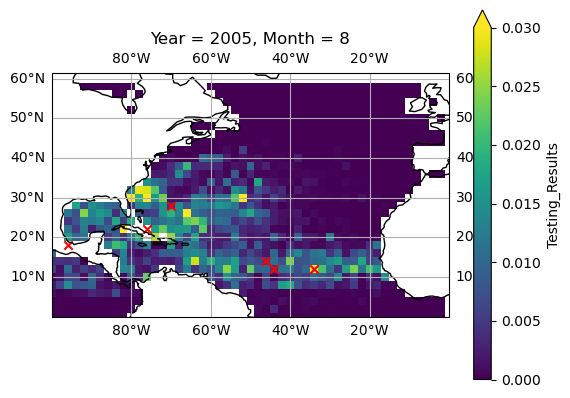

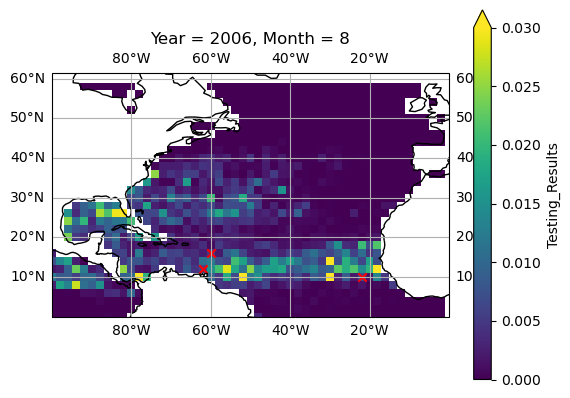

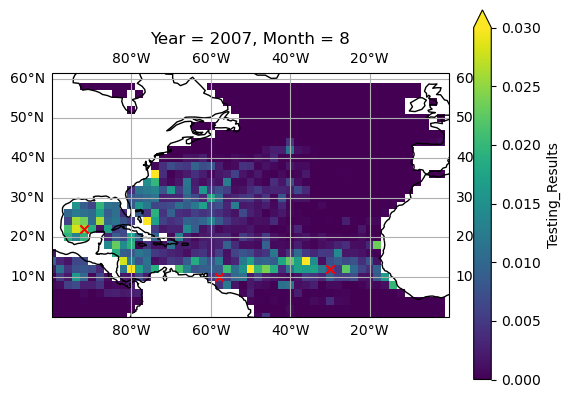

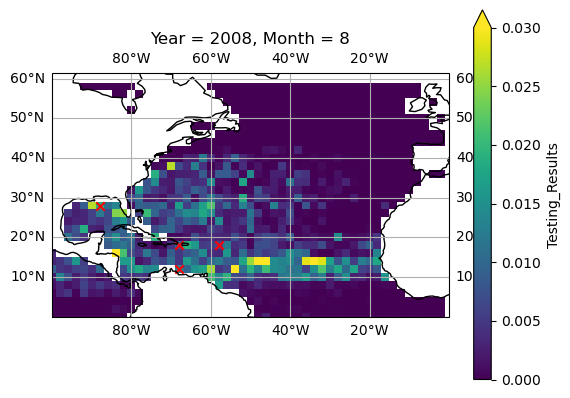

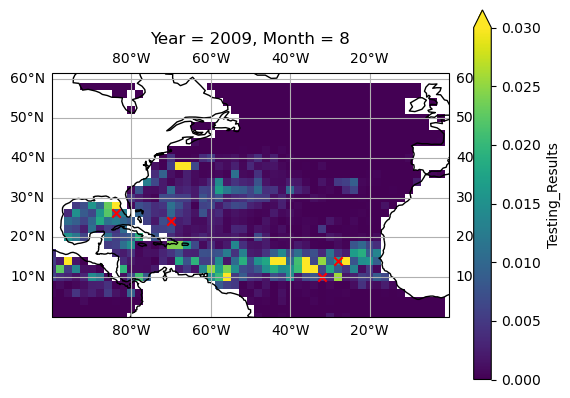

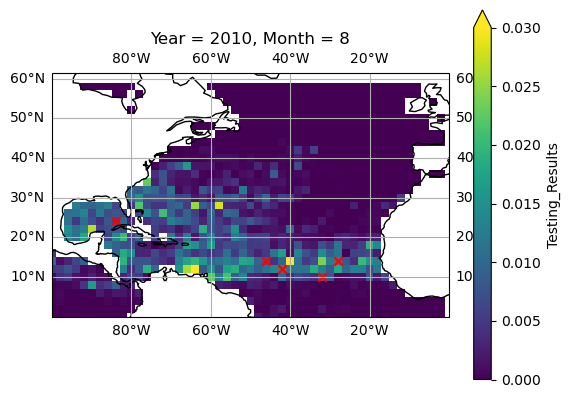

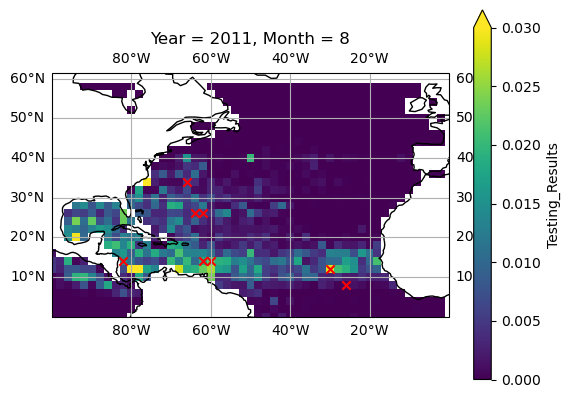

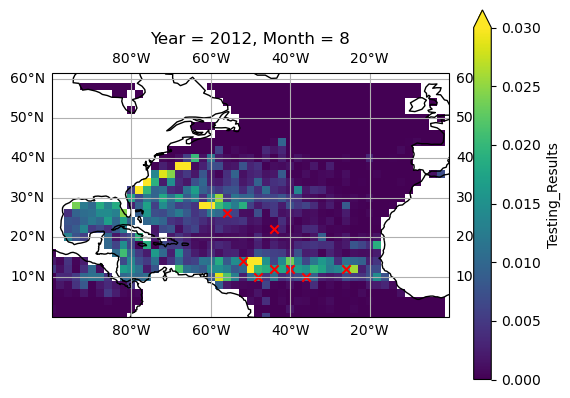

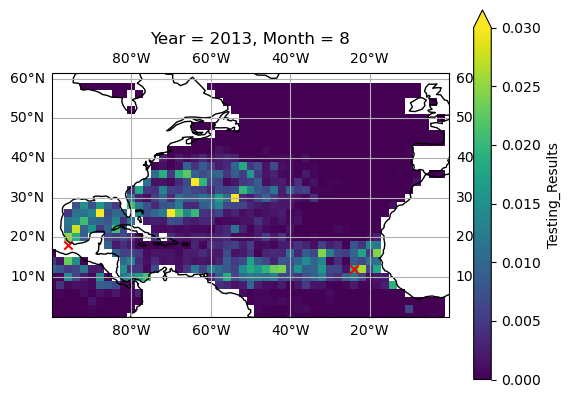

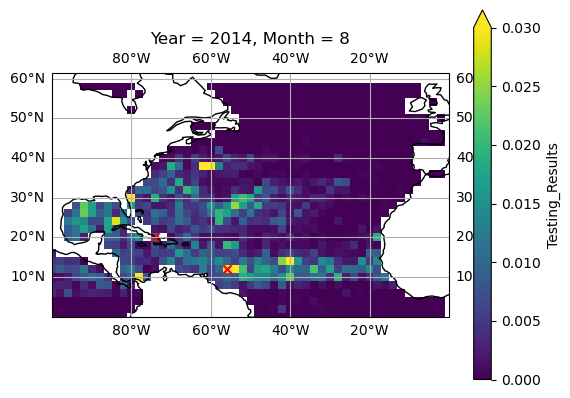

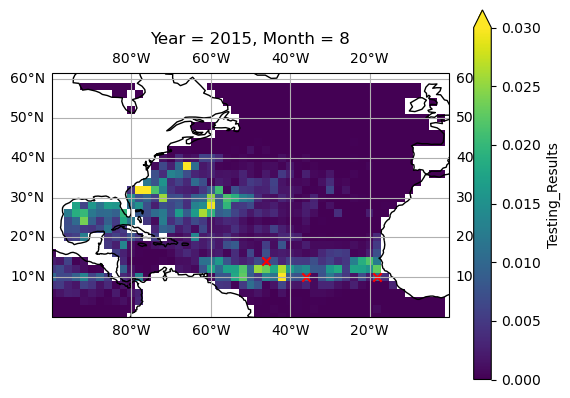

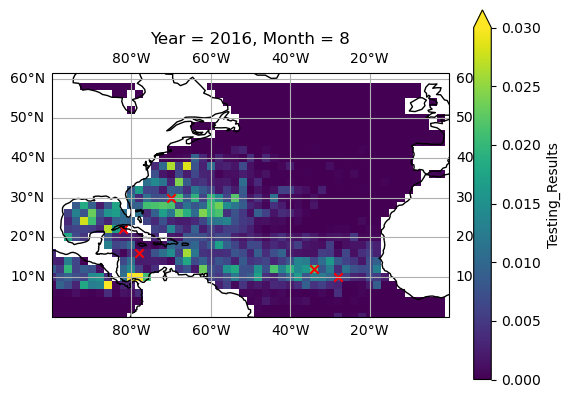

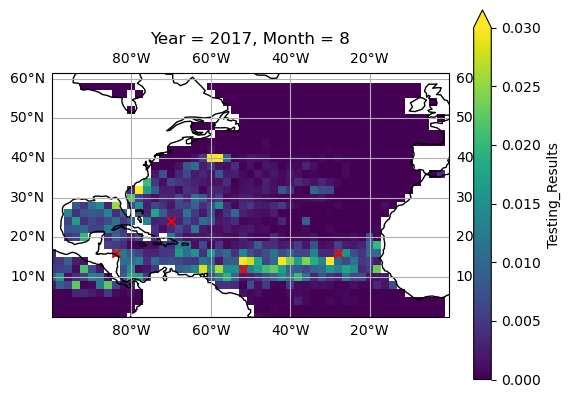

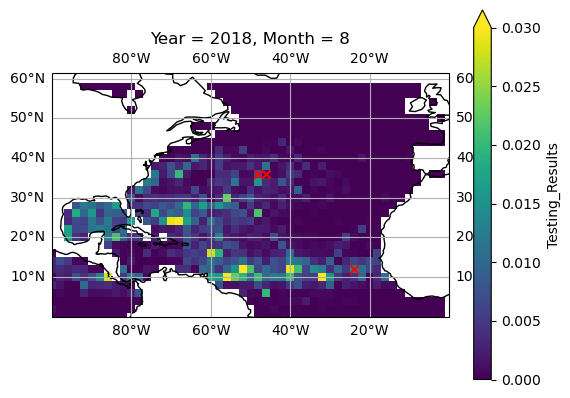

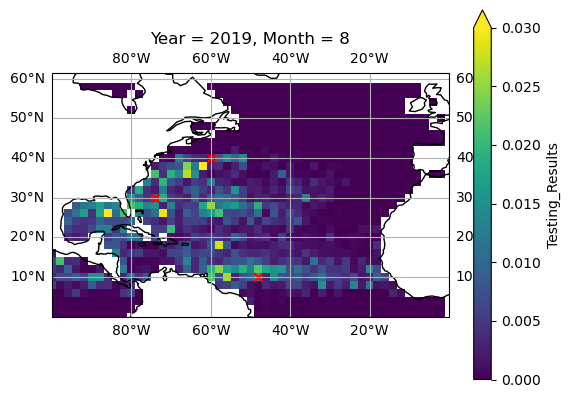

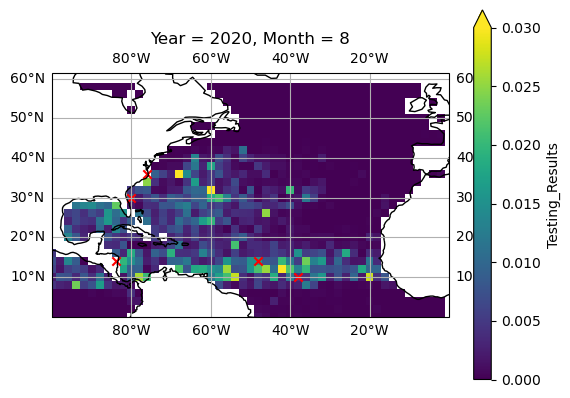

In [15]:
# Plot data
for test_years_now in test_years:
    mo_view = 8
    yr_view = test_years_now
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-100, 0, 0, 50])
    (test_ML_Predict_XR.unstack().sel(Month=mo_view,Year=yr_view)).plot(vmin=0,vmax=0.03)

    scat = test_labels_predropped_read.sel(Month=mo_view,Year=yr_view).stack(new=['Latitude','Longitude'])
    scat_dropped = scat.where(scat>0,drop=True)
    ax.scatter(scat_dropped['Longitude'],scat_dropped['Latitude'],marker='x',color='r')
    if mo_view > 9:
        mostr = str(mo_view)
    else:
        mostr = '0'+str(mo_view)
    timestr = mostr + '_' + str(yr_view)
    
    plt.savefig('/glade/work/acheung/RF_V2_Plots/RF_Reg_plot'+'_'+timestr+'.png',dpi=300)

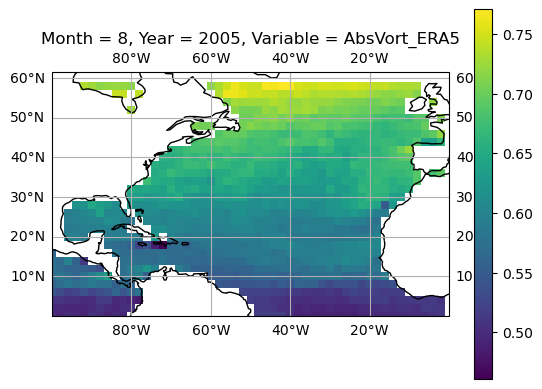

In [11]:
# Plot Environmental Data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 50])
test_env_data[:,0].unstack().sel(Month=8,Year=2005).plot()
plt.savefig("Anomaly_Normalized_Plot")

In [18]:
# # Read in already created genesis (obs) labels
# train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")['Genesis_Grids']
# # train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")['Genesis_Grids']
# # test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# temporal_spatial_smoothing()

# # For points that have no data, take closest point (< 300 km) or delete
# trainunstacklabels = take_closest_point(train_labels_predropped,train_NaNlocs,train_stacked,vars_list)
# testunstacklabels = take_closest_point(test_labels_predropped,test_NaNlocs,test_stacked,vars_list)

# # Stack labels (obs) and drop NaN locations (resulting from no env data, usually over land)
# trainstackedlabels = trainunstacklabels.stack(z=("Month","Latitude","Longitude","Year"))
# train_labels = trainstackedlabels.drop_isel(z=train_NaNlocs)
# teststackedlabels = testunstacklabels.stack(z=("Month","Latitude","Longitude","Year"))
# test_labels = teststackedlabels.drop_isel(z=test_NaNlocs)

# # Fit RF Model
# clf = RandomForestClassifier()
# clf.fit(train_env_data, train_labels.Genesis_Grids)
# probs = clf.predict_proba(test_env_data)
# genesisprobs = 1 - probs[:,0]
# testprobs_formatted = xr.DataArray(genesisprobs,coords=test_labels.coords).unstack() # Genesis probability

# # Unstack and formatted test labels (observed)
# testlabelpoints = test_labels.Genesis_Grids.unstack()
# trainlabelpoints = train_labels.Genesis_Grids.unstack()
# # Save testlabelpoints (observed) and testprobs_formatted (prediction)
# testlabelpoints.to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_label_points_obs.nc")
# trainlabelpoints.to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_label_points_obs.nc")
# testprobs_formatted.to_netcdf("/glade/work/acheung/Initial_RF_Datasets/probabilities_prediction.nc")